### Importing Required libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

### Importing Image Data set from kaggle

In [2]:
# Create the .kaggle directory in the home directory if it doesn't already exist
!mkdir -p ~/.kaggle

# Copy the kaggle.json file to the .kaggle directory
!cp kaggle.json ~/.kaggle/

In [3]:
# Download dataset from kaggle
!kaggle datasets download -d gpiosenka/sports-classification

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/sports-classification
License(s): CC0-1.0
 99% 421M/424M [00:15<00:00, 29.5MB/s]
100% 424M/424M [00:15<00:00, 28.4MB/s]


In [4]:
# Unzip downloaded data
import zipfile
zip_ref = zipfile.ZipFile('/content/sports-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### Pre-Processing Image Data

In [5]:
# Open image and check its dimention
image_path = '/content/train/air hockey/001.jpg'  # Replace with your image path
image = Image.open(image_path)
width, height = image.size
print(f"Image dimensions: {width} x {height}")

Image dimensions: 224 x 224


In [6]:
# Convertion of image data into training, testing and validation data

IMG_WIDTH = 224
IMG_HEIGHT = 224
image_size = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32
BUFFER_SIZE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/train',
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/valid',
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/test',
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [7]:
# Training Data Shape
train_ds_itirator = train_ds.as_numpy_iterator()
train_batch = train_ds_itirator.next()
train_batch[0].shape

(32, 224, 224, 3)

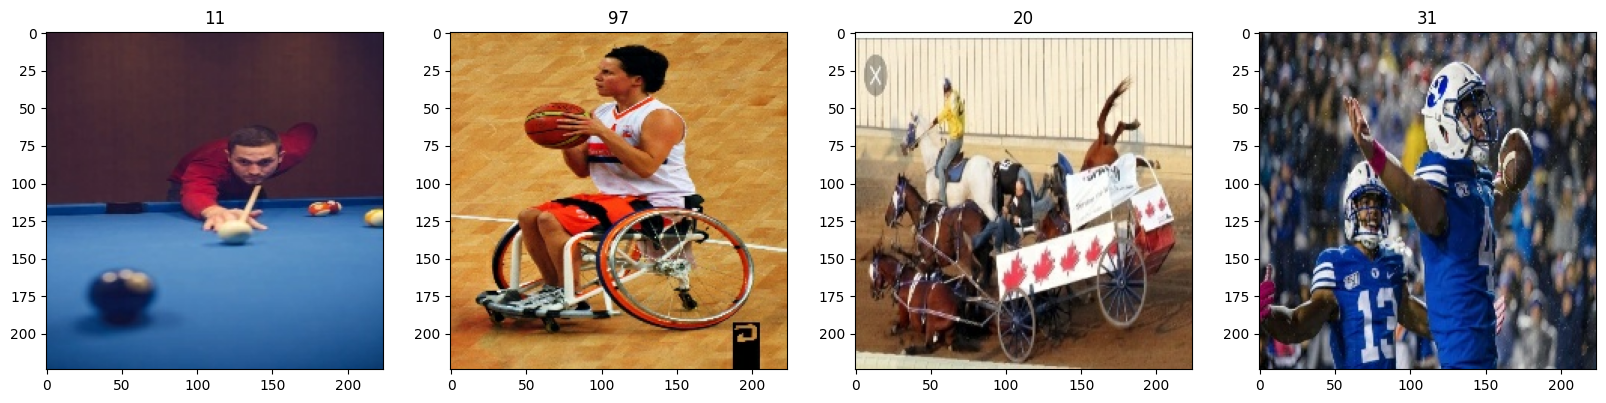

In [9]:
# Visvalizing pre-processed image data

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(train_batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(train_batch[1][idx])

### CNN Model Training

In [10]:
# Importing Required Libraries

import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2  # Choose the model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# Importing ResNet50 CNN Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [12]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=15)  # Adjust based on needs


Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 75s 145ms/step - accuracy: 0.3019 - loss: 17.5401 - val_accuracy: 0.6960 - val_loss: 1.1955
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 59s 107ms/step - accuracy: 0.7912 - loss: 0.8082 - val_accuracy: 0.7120 - val_loss: 1.3897
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 83s 109ms/step - accuracy: 0.8733 - loss: 0.4863 - val_accuracy: 0.7040 - val_loss: 1.8011
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 106ms/step - accuracy: 0.8866 - loss: 0.4791 - val_accuracy: 0.6400 - val_loss: 2.0532
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 83s 109ms/step - accuracy: 0.8943 - loss: 0.5065 - val_accuracy: 0.7140 - val_loss: 1.8131
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 46s 108ms/step - accuracy: 0.9114 - loss: 0.4603 - val_accuracy: 0.7220 - val_loss: 2.2690
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 107ms/step - accuracy: 0.9180 - loss: 0.4632 - val_accuracy: 0.7480 - val_loss: 2.1959
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - accuracy: 0.9220 - loss: 

### Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


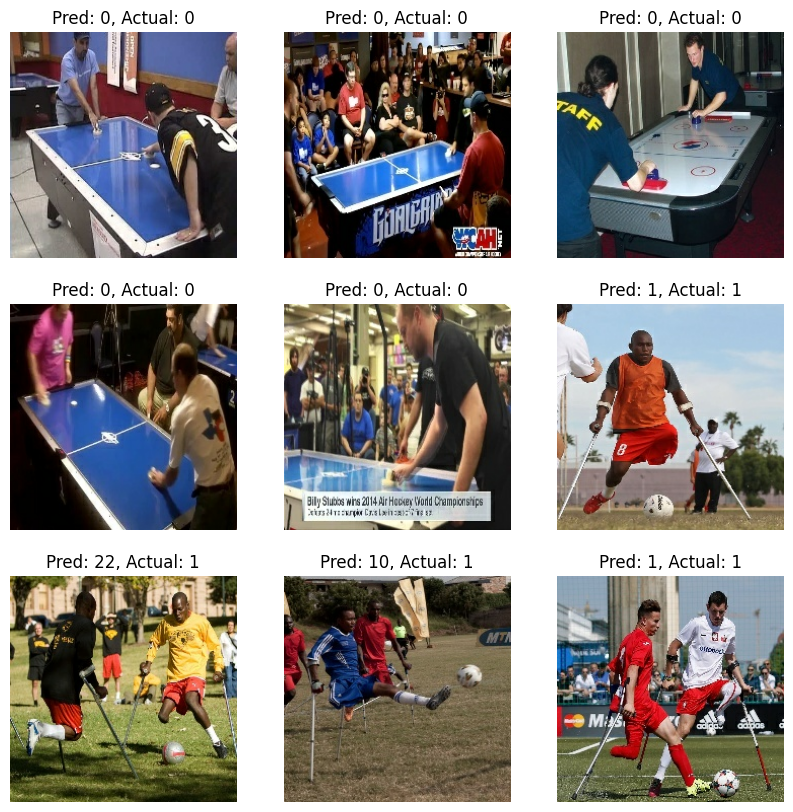

In [18]:
# Get a batch of test data
test_batch = next(iter(test_ds))
images = test_batch[0]
labels = test_batch[1]

# Make predictions
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Display some sample predictions
plt.figure(figsize=(10, 10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(f"Pred: {predicted_labels[i]}, Actual: {labels[i]}")
  plt.axis("off")
plt.show()

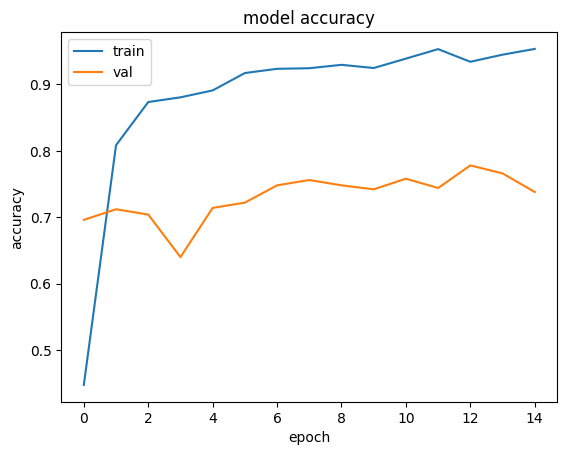

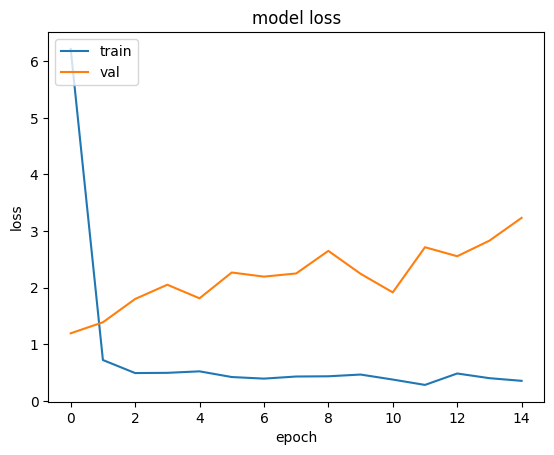

In [17]:
# Training and validation curve of trained model

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


Accuracy: 0.875
Precision: 1.0
Recall: 0.875
F1-Score: 0.921875


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(labels, predicted_labels, average='weighted')  # 'weighted' for multi-class
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(labels, predicted_labels, average='weighted', zero_division=0)
print(f"Recall: {recall}")

# Calculate F1-score
f1 = f1_score(labels, predicted_labels, average='weighted')
print(f"F1-Score: {f1}")

Accuracy: 0.875
Precision: 1.0
Recall: 0.875
F1-Score: 0.921875
